Acknowledgment to the poster of this data set. Username 'fedesoriano' from [Kaggle.com](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset)

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import category_encoders as ce
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, f1_score, plot_confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [112]:
df = pd.read_csv('PredictStrokes/healthcare-dataset-stroke-data.csv')
df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [113]:
#This is just to rename the columns because I don't like underscores
df = df.rename(columns = {'heart_disease': 'heartDisease'})
df = df.rename(columns = {'ever_married': 'everMarried'})
df = df.rename(columns = {'work_type': 'workType'})
df = df.rename(columns = {'Residence_type': 'residenceType'})
df = df.rename(columns = {'avg_glucose_level': 'avgGlucoseLevel'})
df = df.rename(columns = {'smoking_status': 'smokingStatus'})

In [114]:
len(df['id'])

5110

## First look at the data
First thing I noticed is that this data set seem pretty small. 5,110 records. I don't have much room to remove data so I'll need to avoid that as much as possible.

Let's check for anything that might cause problems in our data.

In [115]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heartDisease         0
everMarried          0
workType             0
residenceType        0
avgGlucoseLevel      0
bmi                201
smokingStatus        0
stroke               0
dtype: int64

In [116]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [117]:
df['gender'].value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [118]:
df['everMarried'].value_counts()

Yes    3353
No     1757
Name: everMarried, dtype: int64

In [119]:
df['workType'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: workType, dtype: int64

In [120]:
df['residenceType'].value_counts()

Urban    2596
Rural    2514
Name: residenceType, dtype: int64

In [121]:
df['smokingStatus'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smokingStatus, dtype: int64

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5110 non-null   int64  
 1   gender           5110 non-null   object 
 2   age              5110 non-null   float64
 3   hypertension     5110 non-null   int64  
 4   heartDisease     5110 non-null   int64  
 5   everMarried      5110 non-null   object 
 6   workType         5110 non-null   object 
 7   residenceType    5110 non-null   object 
 8   avgGlucoseLevel  5110 non-null   float64
 9   bmi              4909 non-null   float64
 10  smokingStatus    5110 non-null   object 
 11  stroke           5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


Here are some places where I see some problems.
 - BMI has 201 records with missing info.
 - gender, hypertension, heartDisease, everMarried, residenceType, and stroke look like their a bianary classification. Simply a 'yes' or 'no' answer. No reason we can't make it a '1' or a '0'
 - workType and smokingStatus seems to be broken up into categories. I see no reason why we couldn't use a category encoder.

## Cleaning the data
Let's go through each one and start to solve the problems that come up, starting with dealing with the NaN values in BMI. Our records only have about 5,000 records to start with so removing 201 records is a lot of data being removed. The safest thing to do without swkeing the data is to take an average of everything in this column and fill in the NaN's with the average.

In [123]:
df = df.fillna(df.mean())
df.isna().sum()

id                 0
gender             0
age                0
hypertension       0
heartDisease       0
everMarried        0
workType           0
residenceType      0
avgGlucoseLevel    0
bmi                0
smokingStatus      0
stroke             0
dtype: int64

Sweet. Simple and clean, like my favorite song. Next, let's deal with the columns that could be a binary answer. Since hyptertension, heartDisease, and stroke are already binary 1's and 0's we can leave them alone. Let's deal with gender and everMarried

In [124]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


In [125]:
#These are the lists vlaues we want replaced
genderList = ['Male', 'Female']
marriedList = ['No', 'Yes']
residenceList = ['Urban', 'Rural']

In [126]:
#This function takes in a list of old values to find,
# and the specific column name we wish to apply this function to.
#What it returns is the modified df with the column was spcified,
#turned into a binary classification.

def makeBinary(oldList, columnName):
    binaryList = [0, 1]
    newVals = dict(zip(oldList, binaryList))
    return df[columnName].replace(newVals, inplace = True)

makeBinary(genderList, 'gender')

In [127]:
df['gender'].value_counts()

1        2994
0        2115
Other       1
Name: gender, dtype: int64

Shoots, almost. We missed one. Fortunately, removing one row isn't that big a deal, let's just drop them.

In [128]:
df.drop(df[df['gender'] == 'Other'].index, inplace = True)

In [129]:
df['gender'].value_counts()

1    2994
0    2115
Name: gender, dtype: int64

Success! Next is married. Second verse, same as the first. We'll apply the makeBinary function to the everMarried column the same way, with the marriedList we set aside earlier.

In [130]:
makeBinary(marriedList, 'everMarried')

In [131]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,Urban,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,Rural,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,Rural,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,Urban,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,Rural,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,Urban,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,Rural,166.29,25.600000,formerly smoked,0


In [132]:
df['everMarried'].value_counts()

1    3353
0    1756
Name: everMarried, dtype: int64

In [133]:
makeBinary(residenceList, 'residenceType')

In [134]:
df['residenceType'].value_counts()

0    2596
1    2513
Name: residenceType, dtype: int64

Success again! Let's move on to starting our model!

# Model 1:  Testing different model types
In this section we'll test and fit a number of different models onto our data to see which one's make the most sense and give us the best predictions in our results. We're not just looking at how good our scores are but how accurate our models are from the start.

In [135]:
df

,id,gender,age,hypertension,heartDisease,everMarried,workType,residenceType,avgGlucoseLevel,bmi,smokingStatus,stroke
0,9046,0,67.0,0,1,1,Private,0,228.69,36.600000,formerly smoked,1
1,51676,1,61.0,0,0,1,Self-employed,1,202.21,28.893237,never smoked,1
2,31112,0,80.0,0,1,1,Private,1,105.92,32.500000,never smoked,1
3,60182,1,49.0,0,0,1,Private,0,171.23,34.400000,smokes,1
4,1665,1,79.0,1,0,1,Self-employed,1,174.12,24.000000,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,1,80.0,1,0,1,Private,0,83.75,28.893237,never smoked,0
5106,44873,1,81.0,0,0,1,Self-employed,0,125.20,40.000000,never smoked,0
5107,19723,1,35.0,0,0,1,Self-employed,1,82.99,30.600000,never smoked,0
5108,37544,0,51.0,0,0,1,Private,1,166.29,25.600000,formerly smoked,0


In [136]:
#Data Prep

#Scales my data
scaler = StandardScaler()
#Ecoder to categorize onto cols 'workType' and 'smokingStatus'
encoder = ce.CountEncoder(cols = ['workType', 'smokingStatus'])

xCols = [c for c in df.columns.to_list() if c not in ['stroke']]

x = df[xCols]
y = df['stroke']

xTrain, xTest, yTrain, yTest = train_test_split(
    x, y, test_size=0.33, random_state=42)

xTrainEncoded = encoder.fit_transform(xTrain)
xTestEncoded = encoder.transform(xTest)

xTrainScaled = scaler.fit_transform(xTrainEncoded)
xTestScaled = scaler.transform(xTestEncoded)

C:\Users\jpake\anaconda3\envs\learn-env\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


Accuracy Train Score: 0.7449605609114811
Accuracy Test Score: 0.7313167259786477
-----
F1-Train Score: 0.22399999999999998
F1-Test Score: 0.24625623960066553
-----
Precision Train Score: 0.12962962962962962
Precision Test Score: 0.14653465346534653
-----
Recall Train Score: 0.7449605609114811
Recall Test Score: 0.7313167259786477


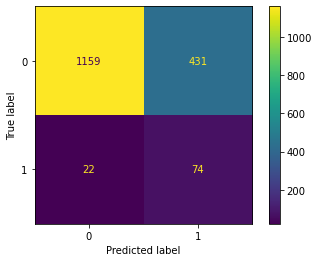

In [137]:
logReg = LogisticRegression(random_state = 123, class_weight = 'balanced')
logReg.fit(xTrainScaled, yTrain)

yPredTrain = logReg.predict(xTrainScaled)
yPredTest = logReg.predict(xTestScaled)

plot_confusion_matrix(logReg, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 0.8317265556529361
Accuracy Test Score: 0.7906287069988137
-----
F1-Train Score: 0.32710280373831774
F1-Test Score: 0.23427331887201736
-----
Precision Train Score: 0.19914651493598862
Precision Test Score: 0.14794520547945206
-----
Recall Train Score: 0.8317265556529361
Recall Test Score: 0.7906287069988137


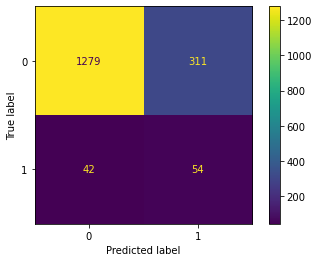

In [138]:
clf = SVC(random_state=0, class_weight = 'balanced')
clf.fit(xTrainScaled, yTrain)

yPredTrain = clf.predict(xTrainScaled)
yPredTest = clf.predict(xTestScaled)

plot_confusion_matrix(clf, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 0.8735027753432661
Accuracy Test Score: 0.8600237247924081
-----
F1-Train Score: 0.21129326047358835
F1-Test Score: 0.25316455696202533
-----
Average Precision Train Score: 0.14646464646464646
Average Precision Test Score: 0.18181818181818182
-----
Recall Train Score: 0.8735027753432661
Recall Test Score: 0.8600237247924081


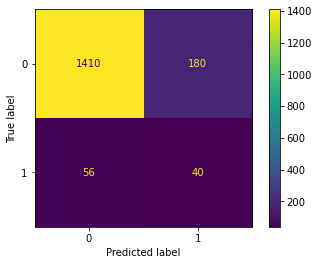

In [139]:
gauNB = GaussianNB()
gauNB.fit(xTrainScaled, yTrain)

yPredTrain = gauNB.predict(xTrainScaled)
yPredTest = gauNB.predict(xTestScaled)

plot_confusion_matrix(gauNB, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

**Note:** This model (DecisionTreeClassifier) works well with interaction terms. Medical data has a lot of interaction terms because they all contribute to the overall health of an individual.

Look into XGBClassifier

Accuracy Train Score: 1.0
Accuracy Test Score: 0.935349940688019
-----
F1-Train Score: 1.0
F1-Test Score: 0.08403361344537814
-----
Average Precision Train Score: 1.0
Average Precision Test Score: 0.21739130434782608
-----
Recall Train Score: 1.0
Recall Test Score: 0.935349940688019


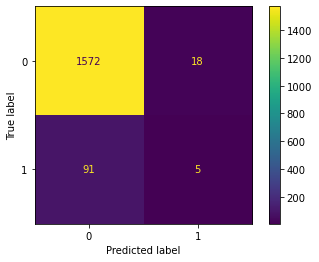

In [140]:
import xgboost as xgb
xgbClass = xgb.XGBClassifier()

xgbClass.fit(xTrainScaled, yTrain)

yPredTrain = xgbClass.predict(xTrainScaled)
yPredTest = xgbClass.predict(xTestScaled)

plot_confusion_matrix(xgbClass, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9080664294187426
-----
F1-Train Score: 1.0
F1-Test Score: 0.10404624277456648
-----
Average Precision Train Score: 1.0
Average Precision Test Score: 0.11688311688311688
-----
Recall Train Score: 1.0
Recall Test Score: 0.9080664294187426


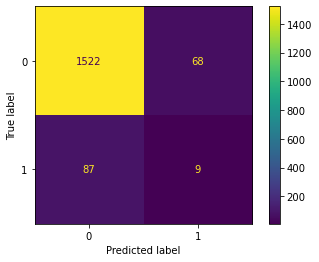

In [141]:
from sklearn.tree import DecisionTreeClassifier
decTree = DecisionTreeClassifier(class_weight='balanced')

decTree.fit(xTrainScaled, yTrain)

yPredTrain = decTree.predict(xTrainScaled)
yPredTest = decTree.predict(xTestScaled)

plot_confusion_matrix(decTree, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

Accuracy Train Score: 1.0
Accuracy Test Score: 0.9424673784104389
-----
F1-Train Score: 1.0
F1-Test Score: 0.0
-----
Average Precision Train Score: 1.0
Average Precision Test Score: 0.0
-----
Recall Train Score: 1.0
Recall Test Score: 0.9424673784104389


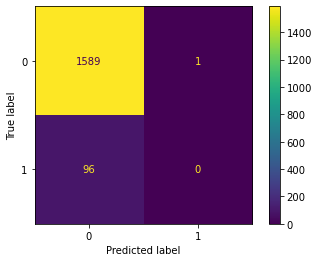

In [142]:
from sklearn.ensemble import RandomForestClassifier
rngForest = RandomForestClassifier(class_weight='balanced')

rngForest.fit(xTrainScaled, yTrain)

yPredTrain = rngForest.predict(xTrainScaled)
yPredTest = rngForest.predict(xTestScaled)

plot_confusion_matrix(rngForest, xTestScaled, yTest)

print(f"Accuracy Train Score: {accuracy_score(yTrain, yPredTrain)}")
print(f"Accuracy Test Score: {accuracy_score(yTest, yPredTest)}")
print('-----')
print(f"F1-Train Score: {f1_score(yTrain, yPredTrain)}")
print(f"F1-Test Score: {f1_score(yTest, yPredTest)}")
print('-----')
print(f"Average Precision Train Score: {precision_score(yTrain, yPredTrain)}")
print(f"Average Precision Test Score: {precision_score(yTest, yPredTest)}")
print('-----')
print(f"Recall Train Score: {recall_score(yTrain, yPredTrain, average='weighted')}")
print(f"Recall Test Score: {recall_score(yTest, yPredTest, average='weighted')}")

It looks like XGBClassifier wins it. It has the least number of false positives and false negatives predicted to begin with.